# Assignment 1: ETL and Linear Regression from scratch

Predicting Attrition based on 8 input variables without using scikit-learn.

## 1. Data Ingestion & 2. Data Processing (EDA / Modeling)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Ingestion
df = pd.read_csv('hr_employee.csv')

# 2. Data Processing (EDA & Modeling)
features = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 
            'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'JobSatisfaction']
target = 'Attrition'

df_selected = df[features + [target]].copy()
df_selected[target] = df_selected[target].apply(lambda x: 1 if x == 'Yes' else 0)
df_selected.fillna(df_selected.mean(), inplace=True)
print(f"Data loaded successfully. Shape: {df_selected.shape}")


Data loaded successfully. Shape: (1470, 9)


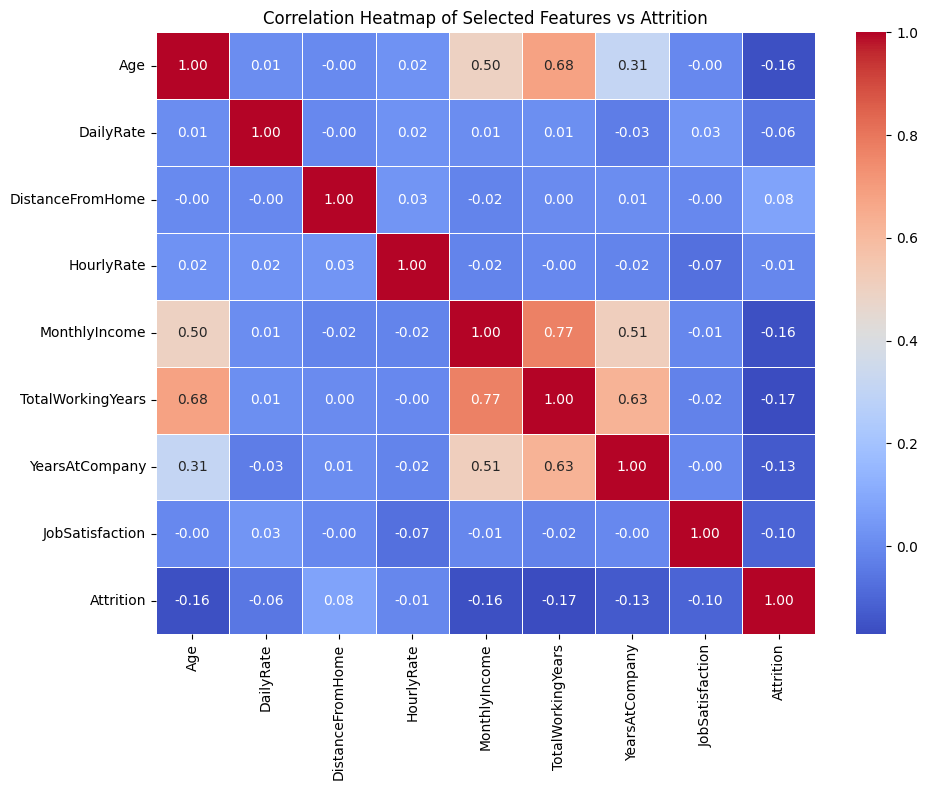

In [2]:
# --- EDA: Correlation Heatmap ---
plt.figure(figsize=(10, 8))
corr_matrix = df_selected.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Selected Features vs Attrition')
plt.tight_layout()
plt.show()


In [3]:
# Extract values
X = df_selected[features].values
y = df_selected[target].values

# Normalization
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

# Add intercept (column of ones)
X_norm = np.c_[np.ones(X_norm.shape[0]), X_norm]

# Linear Regression using Gradient Descent
def compute_cost(X, y, theta):
    m = len(y)
    predictions = X.dot(theta)
    return (1/(2*m)) * np.sum(np.square(predictions - y))

def gradient_descent(X, y, theta, learning_rate, iterations):
    m = len(y)
    cost_history = []
    for _ in range(iterations):
        predictions = X.dot(theta)
        errors = predictions - y
        theta -= (learning_rate * (1/m) * X.T.dot(errors))
        cost_history.append(compute_cost(X, y, theta))
    return theta, cost_history

theta = np.zeros(X_norm.shape[1])
learning_rate = 0.01
iterations = 1000

theta, cost_hist = gradient_descent(X_norm, y, theta, learning_rate, iterations)
print(f"Initial Cost: {cost_hist[0]:.4f}")
print(f"Final Cost after {iterations} iterations: {cost_hist[-1]:.4f}")
print("Model weights (theta):")
for t in theta:
    print(f" {t:.4f}")

# Predictions
df_selected['Prediction'] = X_norm.dot(theta)


Initial Cost: 0.0802
Final Cost after 1000 iterations: 0.0638
Model weights (theta):
 0.1612
 -0.0329
 -0.0194
 0.0284
 -0.0057
 -0.0224
 -0.0105
 -0.0220
 -0.0384


## 3. Load to MySQL Database & 4. Query Output

Using `mysql.connector` to load the predicted data into `hr_employee` database.

In [4]:
import mysql.connector

# 3. Load to MySQL database (hr_employee)
try:
    conn = mysql.connector.connect(
        host="localhost",
        user="root",
        password="",  # Update with actual password if needed
        database="hr_employee"
    )
    cursor = conn.cursor()
    
    # Create table if not exists
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS hr_predictions (
            Age INT,
            DailyRate INT,
            DistanceFromHome INT,
            HourlyRate INT,
            MonthlyIncome INT,
            TotalWorkingYears INT,
            YearsAtCompany INT,
            JobSatisfaction INT,
            Attrition INT,
            Prediction FLOAT
        )
    ''')
    
    # Clear table to avoid duplicates on re-run
    cursor.execute('TRUNCATE TABLE hr_predictions')
    
    # Insert data
    insert_query = '''
        INSERT INTO hr_predictions 
        (Age, DailyRate, DistanceFromHome, HourlyRate, MonthlyIncome, 
         TotalWorkingYears, YearsAtCompany, JobSatisfaction, Attrition, Prediction)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    '''
    
    # Prepare data tuples
    data_tuples = []
    for row in df_selected.itertuples(index=False):
        # Cast numpy types to native Python types for MySQL connector
        data_tuples.append(tuple(float(x) if isinstance(x, np.float64) 
                                 else int(x) if isinstance(x, (np.int64, np.int32)) 
                                 else x for x in row))
        
    cursor.executemany(insert_query, data_tuples)
    conn.commit()
    print("Data loaded to MySQL successfully.")
    
    # 4. Create a simple query and output
    cursor.execute("SELECT Age, Attrition, Prediction FROM hr_predictions LIMIT 5")
    rows = cursor.fetchall()
    print("Query Output from MySQL:")
    for row in rows:
        print(row)
        
    cursor.close()
    conn.close()
except Exception as e:
    # In case MySQL is not running or credentials differ
    print(f"MySQL Error: {e}")


Data loaded to MySQL successfully.
Query Output from MySQL:
(41, 1, 0.0617134)
(49, 0, 0.163017)
(37, 1, 0.14348)
(33, 0, 0.136537)
(27, 0, 0.254197)
